In [116]:
import pandas as pd
df=pd.read_csv('SOCATv2024_Indian1.csv',low_memory=False)

In [117]:
df=df.rename(columns={'longitude [dec.deg.E]' : 'Lon', 'latitude [dec.deg.N]' : 'Lat',
                      'yr':'year',
                      'mon':'month',
                      'ss':'second',
                      'hh':'hour',
                      'mm':'minute',
                      'sal' : 'Salinity',
                      'SST [deg.C]' : 'SST',
                      'PPPP [hPa]' : 'Atmospheric_Pressure',
                      'fCO2water_SST_wet [uatm]':'fCO2water_SST_wet'})

In [120]:
data=df[['Lat', 'Lon', 'day', 'month', 'year', 'hour', 'minute', 'second', 'Salinity', 'SST', 'Atmospheric_Pressure', 'fCO2water_SST_wet']].copy()

In [122]:
arabian_sea_lat_range = (0, 22)
arabian_sea_lon_range = (50, 75)

In [124]:
# Filter data for Arabian sea
arabian_sea = data[(data['Lat'] >= arabian_sea_lat_range[0]) & (data['Lat'] <= arabian_sea_lat_range[1]) &
                      (data['Lon'] >= arabian_sea_lon_range[0]) & (data['Lon'] <= arabian_sea_lon_range[1])].reset_index(drop=True)

In [55]:
arabian_sea=arabian_sea.drop(['Lat','Lon', 'day', 'month', 'hour', 'minute', 'second'], axis=1)

In [57]:
arabian_sea

,year,Salinity,SST,Atmospheric_Pressure,fCO2water_SST_wet
0,1997,36.450,28.65,1007.8,372.8
1,1997,36.450,28.65,1007.8,372.3
2,1997,36.450,28.65,1007.8,372.1
3,1997,36.450,28.65,1007.8,372.8
4,1997,36.450,28.65,1007.8,372.5
...,...,...,...,...,...
93566,1999,35.369,27.23,1011.2,382.5
93567,1999,35.368,27.24,1011.3,382.0
93568,1999,35.367,27.25,1011.2,381.9
93569,1999,35.368,27.23,1011.1,381.7


In [59]:
arabian_sea['year'].value_counts()

year
1995    64837
1997    15679
2018     8285
1999     2607
2014      640
1963      451
1962      418
1991      414
1992      240
Name: count, dtype: int64

In [61]:
# Splitting data
train_df = arabian_sea[arabian_sea['year'] != 2014].reset_index()
test_df = arabian_sea[arabian_sea['year'] == 2014].reset_index()

In [63]:
train_df.drop(['index', 'year'], axis=1, inplace=True)

In [65]:
train_df.isna().sum()

Salinity                  871
SST                         0
Atmospheric_Pressure    24873
fCO2water_SST_wet       35109
dtype: int64

In [67]:
test_df.drop(['index', 'year'], axis=1, inplace=True)

In [69]:
test_df.isna().sum()

Salinity                 0
SST                      0
Atmospheric_Pressure     0
fCO2water_SST_wet       20
dtype: int64

In [81]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [73]:
x = train_df.drop('fCO2water_SST_wet', axis=1)
y = train_df['fCO2water_SST_wet']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [75]:
# Fill missing values with median
median_fCO2 = y_train.median(skipna=True)
y_train.fillna(median_fCO2, inplace=True)
y_test.fillna(median_fCO2, inplace=True)

In [83]:
xgb_model=XGBRegressor(n_estimators=800, max_depth=4, random_state=42)
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [85]:
# Prepare test data
test_features = test_df.drop('fCO2water_SST_wet', axis=1)
test_target = test_df['fCO2water_SST_wet']

In [87]:
# Fill missing values with median
median_fCO2 = test_target.median(skipna=True)
test_target.fillna(median_fCO2, inplace=True)

In [89]:
# Predictions
y_train_pred = xgb_model.predict(x_train)
y_pred = xgb_model.predict(test_features)

# Compute RMSE
training_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_rmse = np.sqrt(mean_squared_error(test_target, y_pred))

print('XGBoost Regression :')
print('Training RMSE :', training_rmse)
print('Testing RMSE :', testing_rmse)

XGBoost Regression :
Training RMSE : 4.146009229358516
Testing RMSE : 11.1333983900724


<Figure size 1200x600 with 0 Axes>

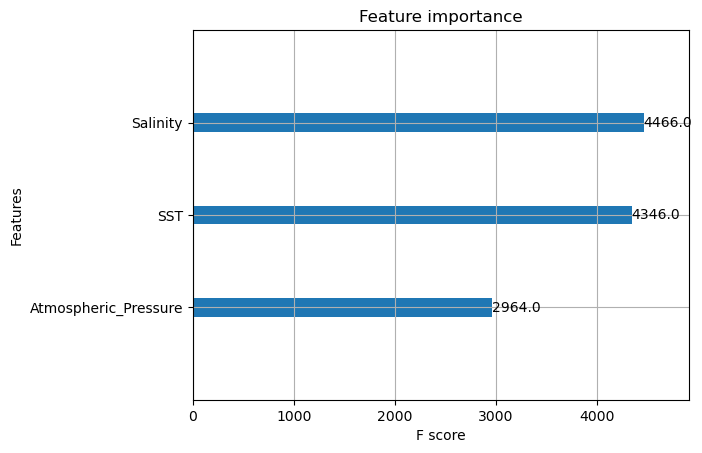

In [91]:
import xgboost as xgb
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model)
plt.show()

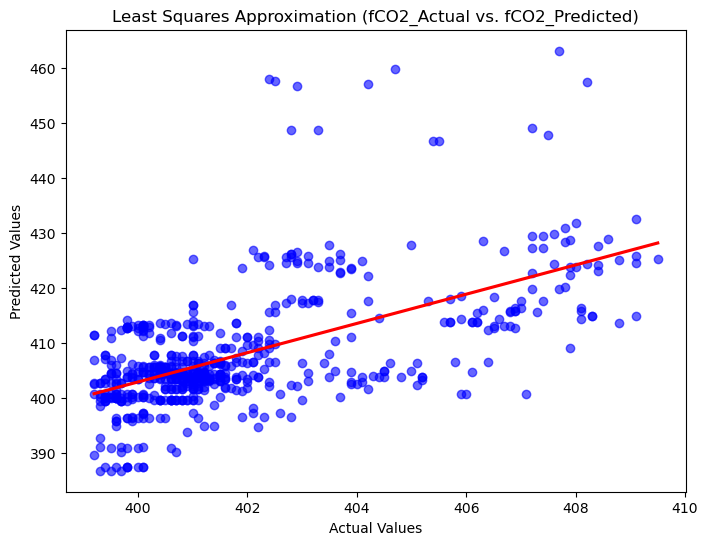

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.regplot(x=test_target, y=y_pred, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"}, ci=None)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Least Squares Approximation (fCO2_Actual vs. fCO2_Predicted)")
plt.show()

In [126]:
arabian_sea=arabian_sea.drop(['Lat', 'Lon', 'day', 'month', 'year', 'hour', 'minute', 'second'], axis=1)

In [128]:
data=arabian_sea.to_csv('fco2_arabian_sea.csv')

### 15% nan

In [89]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
df1=pd.read_csv('fCO2_arabian_sea.csv')
df1

,Unnamed: 0,Salinity,SST,Atmospheric_Pressure,fCO2water_SST_wet
0,0,36.450,28.65,1007.8,372.8
1,1,36.450,28.65,1007.8,372.3
2,2,36.450,28.65,1007.8,372.1
3,3,36.450,28.65,1007.8,372.8
4,4,36.450,28.65,1007.8,372.5
...,...,...,...,...,...
93566,93566,35.369,27.23,1011.2,382.5
93567,93567,35.368,27.24,1011.3,382.0
93568,93568,35.367,27.25,1011.2,381.9
93569,93569,35.368,27.23,1011.1,381.7


In [91]:
df1.isna().sum()

Unnamed: 0                  0
Salinity                  871
SST                         0
Atmospheric_Pressure    24873
fCO2water_SST_wet       35129
dtype: int64

In [93]:
df1=df1.drop('Unnamed: 0', axis=1)

nan_rows = df1[df1[['Salinity', 'Atmospheric_Pressure','fCO2water_SST_wet']].isna().any(axis=1)]

# Calculate 15% of the NaN rows
num_nan_to_select = int(0.15 * len(nan_rows))

# Randomly select 15% of NaN rows
nan_sample = nan_rows.sample(n=num_nan_to_select, random_state=42).reset_index(drop=True)

# Get rows that are fully non-NaN in fCO2water_SST_wet

non_nan_rows = df1.dropna(subset=['Atmospheric_Pressure','fCO2water_SST_wet']).reset_index(drop=True)

In [94]:
non_nan_rows.isna().sum()

Salinity                0
SST                     0
Atmospheric_Pressure    0
fCO2water_SST_wet       0
dtype: int64

In [96]:
# Combine 15% NaN rows with all non-NaN rows
new_df = pd.concat([nan_sample, non_nan_rows])

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [99]:
x=new_df.drop('fCO2water_SST_wet', axis=1)
y=new_df['fCO2water_SST_wet']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

median_fCO2=y_train.median(skipna=True)
y_train=y_train.fillna(median_fCO2)
y_test1=y_test1.fillna(median_fCO2)

import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test1)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 4
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=2000,  # Max rounds
    evals=evals,
    early_stopping_rounds=5,  # Stop if no improvement in last 5 rounds
    verbose_eval=True
)

[0]	train-rmse:31.35062	validation-rmse:30.80117
[1]	train-rmse:28.83074	validation-rmse:28.31737
[2]	train-rmse:26.61010	validation-rmse:26.14059
[3]	train-rmse:24.64636	validation-rmse:24.20902
[4]	train-rmse:22.88338	validation-rmse:22.47732
[5]	train-rmse:21.23121	validation-rmse:20.85831
[6]	train-rmse:19.86660	validation-rmse:19.51117
[7]	train-rmse:18.70941	validation-rmse:18.37294
[8]	train-rmse:17.66390	validation-rmse:17.34748
[9]	train-rmse:16.76710	validation-rmse:16.47443
[10]	train-rmse:15.93394	validation-rmse:15.66084
[11]	train-rmse:15.20332	validation-rmse:14.94710
[12]	train-rmse:14.57476	validation-rmse:14.34049
[13]	train-rmse:14.06908	validation-rmse:13.84657
[14]	train-rmse:13.60204	validation-rmse:13.40173
[15]	train-rmse:13.22255	validation-rmse:13.03389
[16]	train-rmse:12.90194	validation-rmse:12.72832
[17]	train-rmse:12.53873	validation-rmse:12.37916
[18]	train-rmse:12.30127	validation-rmse:12.15251
[19]	train-rmse:12.02678	validation-rmse:11.88878
[20]	train

In [100]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Get the best iteration
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")


y_train_pred=model.predict(dtrain, iteration_range=(0, best_iteration))
y_pred1=model.predict(dval, iteration_range=(0, best_iteration))

training_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_rmse=np.sqrt(mean_squared_error(y_test1, y_pred1))

print('XGBoost Regression :')
print('Training RMSE :',training_rmse)
print('Testing RMSE :',testing_rmse)

Best iteration: 1810
XGBoost Regression :
Training RMSE : 3.723701989321363
Testing RMSE : 4.403756914938142


### 30% 

In [104]:
import pandas as pd
df1=pd.read_csv('fCO2_arabian_sea.csv')
df1=df1.drop('Unnamed: 0', axis=1)

nan_rows = df1[df1[['Salinity', 'Atmospheric_Pressure','fCO2water_SST_wet']].isna().any(axis=1)]

# Calculate 30% of the NaN rows
num_nan_to_select = int(0.30 * len(nan_rows))

# Randomly select 30% of NaN rows
nan_sample = nan_rows.sample(n=num_nan_to_select, random_state=42).reset_index(drop=True)

# Get rows that are fully non-NaN in fCO2water_SST_wet

non_nan_rows = df1.dropna(subset=['Atmospheric_Pressure','fCO2water_SST_wet']).reset_index(drop=True)

In [106]:
# Combine 30% NaN rows with all non-NaN rows
new_df = pd.concat([nan_sample, non_nan_rows])

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [108]:
x=new_df.drop('fCO2water_SST_wet', axis=1)
y=new_df['fCO2water_SST_wet']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test2 = train_test_split(x, y, test_size=0.2, random_state=42)

median_fCO2=y_train.median(skipna=True)
y_train=y_train.fillna(median_fCO2)
y_test2=y_test2.fillna(median_fCO2)

import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test2)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 4
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=2000,  # Max rounds
    evals=evals,
    early_stopping_rounds=5,  # Stop if no improvement in last 5 rounds
    verbose_eval=True
)

[0]	train-rmse:29.96832	validation-rmse:29.75900
[1]	train-rmse:27.58344	validation-rmse:27.37933
[2]	train-rmse:25.46793	validation-rmse:25.26842
[3]	train-rmse:23.62047	validation-rmse:23.42208
[4]	train-rmse:21.92905	validation-rmse:21.74018
[5]	train-rmse:20.47148	validation-rmse:20.28522
[6]	train-rmse:19.19225	validation-rmse:19.01955
[7]	train-rmse:18.07840	validation-rmse:17.91440
[8]	train-rmse:17.09206	validation-rmse:16.92296
[9]	train-rmse:16.21292	validation-rmse:16.06734
[10]	train-rmse:15.42184	validation-rmse:15.28817
[11]	train-rmse:14.79244	validation-rmse:14.66212
[12]	train-rmse:14.24628	validation-rmse:14.13216
[13]	train-rmse:13.68809	validation-rmse:13.58894
[14]	train-rmse:13.23826	validation-rmse:13.15454
[15]	train-rmse:12.88916	validation-rmse:12.81024
[16]	train-rmse:12.51523	validation-rmse:12.44540
[17]	train-rmse:12.24224	validation-rmse:12.17503
[18]	train-rmse:11.93214	validation-rmse:11.88618
[19]	train-rmse:11.73012	validation-rmse:11.68325
[20]	train

In [109]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Get the best iteration
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")


y_train_pred=model.predict(dtrain, iteration_range=(0, best_iteration))
y_pred2=model.predict(dval, iteration_range=(0, best_iteration))

training_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_rmse=np.sqrt(mean_squared_error(y_test2, y_pred2))

print('XGBoost Regression :')
print('Training RMSE :',training_rmse)
print('Testing RMSE :',testing_rmse)

Best iteration: 1390
XGBoost Regression :
Training RMSE : 4.200521866883214
Testing RMSE : 4.766160048638045


### 45%

In [113]:
import pandas as pd
df1=pd.read_csv('fCO2_arabian_sea.csv')
df1=df1.drop('Unnamed: 0', axis=1)

nan_rows = df1[df1[['Salinity', 'Atmospheric_Pressure','fCO2water_SST_wet']].isna().any(axis=1)]

# Calculate 45% of the NaN rows
num_nan_to_select = int(0.45 * len(nan_rows))

# Randomly select 45% of NaN rows
nan_sample = nan_rows.sample(n=num_nan_to_select, random_state=42).reset_index(drop=True)

# Get rows that are fully non-NaN in fCO2water_SST_wet

non_nan_rows = df1.dropna(subset=['Atmospheric_Pressure','fCO2water_SST_wet']).reset_index(drop=True)

# Combine 45% NaN rows with all non-NaN rows
new_df = pd.concat([nan_sample, non_nan_rows])

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [115]:
x=new_df.drop('fCO2water_SST_wet', axis=1)
y=new_df['fCO2water_SST_wet']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test3 = train_test_split(x, y, test_size=0.2, random_state=42)

median_fCO2=y_train.median(skipna=True)
y_train=y_train.fillna(median_fCO2)
y_test3=y_test3.fillna(median_fCO2)

import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test3)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 4
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=2000,  # Max rounds
    evals=evals,
    early_stopping_rounds=5,  # Stop if no improvement in last 5 rounds
    verbose_eval=True
)

[0]	train-rmse:28.66447	validation-rmse:29.28596
[1]	train-rmse:26.41745	validation-rmse:26.98163
[2]	train-rmse:24.45856	validation-rmse:24.97230
[3]	train-rmse:22.81767	validation-rmse:23.28124
[4]	train-rmse:21.41973	validation-rmse:21.83515
[5]	train-rmse:19.98656	validation-rmse:20.36723
[6]	train-rmse:18.77535	validation-rmse:19.11676
[7]	train-rmse:17.81165	validation-rmse:18.11764
[8]	train-rmse:16.85741	validation-rmse:17.13435
[9]	train-rmse:16.05018	validation-rmse:16.29626
[10]	train-rmse:15.24052	validation-rmse:15.46635
[11]	train-rmse:14.63716	validation-rmse:14.83665
[12]	train-rmse:14.12137	validation-rmse:14.30050
[13]	train-rmse:13.58059	validation-rmse:13.74840
[14]	train-rmse:13.20754	validation-rmse:13.35944
[15]	train-rmse:12.79160	validation-rmse:12.93439
[16]	train-rmse:12.51641	validation-rmse:12.64890
[17]	train-rmse:12.19624	validation-rmse:12.32633
[18]	train-rmse:11.90192	validation-rmse:12.02877
[19]	train-rmse:11.70304	validation-rmse:11.82323
[20]	train

In [116]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Get the best iteration
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")


y_train_pred=model.predict(dtrain, iteration_range=(0, best_iteration))
y_pred3=model.predict(dval, iteration_range=(0, best_iteration))

training_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_rmse=np.sqrt(mean_squared_error(y_test3, y_pred3))

print('XGBoost Regression :')
print('Training RMSE :',training_rmse)
print('Testing RMSE :',testing_rmse)

Best iteration: 1282
XGBoost Regression :
Training RMSE : 4.417533668204198
Testing RMSE : 4.9676490320138065


### 60%

In [120]:
import pandas as pd
df1=pd.read_csv('fCO2_arabian_sea.csv')
df1=df1.drop('Unnamed: 0', axis=1)

nan_rows = df1[df1[['Salinity', 'Atmospheric_Pressure','fCO2water_SST_wet']].isna().any(axis=1)]

# Calculate 60% of the NaN rows
num_nan_to_select = int(0.60 * len(nan_rows))

# Randomly select 60% of NaN rows
nan_sample = nan_rows.sample(n=num_nan_to_select, random_state=42).reset_index(drop=True)

# Get rows that are fully non-NaN in fCO2water_SST_wet

non_nan_rows = df1.dropna(subset=['Atmospheric_Pressure','fCO2water_SST_wet']).reset_index(drop=True)

# Combine 60% NaN rows with all non-NaN rows
new_df = pd.concat([nan_sample, non_nan_rows])

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [122]:
x=new_df.drop('fCO2water_SST_wet', axis=1)
y=new_df['fCO2water_SST_wet']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test4 = train_test_split(x, y, test_size=0.2, random_state=42)

median_fCO2=y_train.median(skipna=True)
y_train=y_train.fillna(median_fCO2)
y_test4=y_test4.fillna(median_fCO2)

import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test4)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 4
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=2000,  # Max rounds
    evals=evals,
    early_stopping_rounds=5,  # Stop if no improvement in last 5 rounds
    verbose_eval=True
)

[0]	train-rmse:27.80800	validation-rmse:27.67251
[1]	train-rmse:25.78313	validation-rmse:25.68131
[2]	train-rmse:24.05055	validation-rmse:23.97761
[3]	train-rmse:22.34564	validation-rmse:22.28611
[4]	train-rmse:20.86705	validation-rmse:20.81638
[5]	train-rmse:19.54007	validation-rmse:19.50157
[6]	train-rmse:18.30332	validation-rmse:18.28565
[7]	train-rmse:17.28626	validation-rmse:17.28109
[8]	train-rmse:16.35730	validation-rmse:16.37069
[9]	train-rmse:15.59695	validation-rmse:15.62642
[10]	train-rmse:14.92089	validation-rmse:14.95907
[11]	train-rmse:14.36045	validation-rmse:14.40974
[12]	train-rmse:13.87487	validation-rmse:13.93256
[13]	train-rmse:13.33676	validation-rmse:13.40459
[14]	train-rmse:12.88913	validation-rmse:12.96535
[15]	train-rmse:12.56694	validation-rmse:12.64956
[16]	train-rmse:12.21936	validation-rmse:12.30767
[17]	train-rmse:11.98047	validation-rmse:12.07458
[18]	train-rmse:11.78635	validation-rmse:11.88341
[19]	train-rmse:11.53779	validation-rmse:11.64459
[20]	train

In [123]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Get the best iteration
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")


y_train_pred=model.predict(dtrain, iteration_range=(0, best_iteration))
y_pred4=model.predict(dval, iteration_range=(0, best_iteration))

training_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_rmse=np.sqrt(mean_squared_error(y_test4, y_pred4))

print('XGBoost Regression :')
print('Training RMSE :',training_rmse)
print('Testing RMSE :',testing_rmse)

Best iteration: 970
XGBoost Regression :
Training RMSE : 4.666813198399325
Testing RMSE : 5.0479347369883065


### 75%

In [127]:
import pandas as pd
df1=pd.read_csv('fCO2_arabian_sea.csv')
df1=df1.drop('Unnamed: 0', axis=1)

nan_rows = df1[df1[['Salinity', 'Atmospheric_Pressure','fCO2water_SST_wet']].isna().any(axis=1)]

# Calculate 75% of the NaN rows
num_nan_to_select = int(0.75 * len(nan_rows))

# Randomly select 75% of NaN rows
nan_sample = nan_rows.sample(n=num_nan_to_select, random_state=42).reset_index(drop=True)

# Get rows that are fully non-NaN in fCO2water_SST_wet

non_nan_rows = df1.dropna(subset=['Atmospheric_Pressure','fCO2water_SST_wet']).reset_index(drop=True)

# Combine 75% NaN rows with all non-NaN rows
new_df = pd.concat([nan_sample, non_nan_rows])

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [129]:
x=new_df.drop('fCO2water_SST_wet', axis=1)
y=new_df['fCO2water_SST_wet']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test5 = train_test_split(x, y, test_size=0.2, random_state=42)

median_fCO2=y_train.median(skipna=True)
y_train=y_train.fillna(median_fCO2)
y_test5=y_test5.fillna(median_fCO2)

import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test5)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 4
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=2000,  # Max rounds
    evals=evals,
    early_stopping_rounds=5,  # Stop if no improvement in last 5 rounds
    verbose_eval=True
)

[0]	train-rmse:26.78820	validation-rmse:27.27290
[1]	train-rmse:24.91316	validation-rmse:25.33358
[2]	train-rmse:23.08538	validation-rmse:23.44722
[3]	train-rmse:21.48978	validation-rmse:21.79638
[4]	train-rmse:20.12306	validation-rmse:20.38946
[5]	train-rmse:18.99096	validation-rmse:19.21773
[6]	train-rmse:17.81663	validation-rmse:18.01799
[7]	train-rmse:16.84872	validation-rmse:17.01930
[8]	train-rmse:16.12405	validation-rmse:16.26472
[9]	train-rmse:15.35228	validation-rmse:15.46842
[10]	train-rmse:14.67962	validation-rmse:14.77640
[11]	train-rmse:14.12848	validation-rmse:14.20552
[12]	train-rmse:13.65120	validation-rmse:13.70587
[13]	train-rmse:13.16544	validation-rmse:13.19444
[14]	train-rmse:12.81875	validation-rmse:12.83020
[15]	train-rmse:12.52353	validation-rmse:12.52048
[16]	train-rmse:12.18989	validation-rmse:12.17065
[17]	train-rmse:11.88887	validation-rmse:11.85771
[18]	train-rmse:11.67900	validation-rmse:11.63788
[19]	train-rmse:11.41786	validation-rmse:11.36132
[20]	train

In [133]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Get the best iteration
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")


y_train_pred=model.predict(dtrain, iteration_range=(0, best_iteration))
y_pred5=model.predict(dval, iteration_range=(0, best_iteration))

training_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_rmse=np.sqrt(mean_squared_error(y_test5, y_pred5))

print('XGBoost Regression :')
print('Training RMSE :',training_rmse)
print('Testing RMSE :',testing_rmse)

Best iteration: 1558
XGBoost Regression :
Training RMSE : 4.423757518543521
Testing RMSE : 4.576599927066875


### 90%

In [136]:
import pandas as pd
df1=pd.read_csv('fCO2_arabian_sea.csv')
df1=df1.drop('Unnamed: 0', axis=1)

nan_rows = df1[df1[['Salinity', 'Atmospheric_Pressure','fCO2water_SST_wet']].isna().any(axis=1)]

# Calculate 90% of the NaN rows
num_nan_to_select = int(0.90 * len(nan_rows))

# Randomly select 90% of NaN rows
nan_sample = nan_rows.sample(n=num_nan_to_select, random_state=42).reset_index(drop=True)

# Get rows that are fully non-NaN in fCO2water_SST_wet

non_nan_rows = df1.dropna(subset=['Atmospheric_Pressure','fCO2water_SST_wet']).reset_index(drop=True)

# Combine 90% NaN rows with all non-NaN rows
new_df = pd.concat([nan_sample, non_nan_rows])

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [138]:
x=new_df.drop('fCO2water_SST_wet', axis=1)
y=new_df['fCO2water_SST_wet']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test6 = train_test_split(x, y, test_size=0.2, random_state=42)

median_fCO2=y_train.median(skipna=True)
y_train=y_train.fillna(median_fCO2)
y_test6=y_test6.fillna(median_fCO2)

import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test6)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 4
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=2000,  # Max rounds
    evals=evals,
    early_stopping_rounds=5,  # Stop if no improvement in last 5 rounds
    verbose_eval=True
)

[0]	train-rmse:26.15680	validation-rmse:25.96217
[1]	train-rmse:24.31280	validation-rmse:24.13389
[2]	train-rmse:22.65255	validation-rmse:22.48965
[3]	train-rmse:21.08077	validation-rmse:20.93147
[4]	train-rmse:19.81814	validation-rmse:19.68446
[5]	train-rmse:18.58277	validation-rmse:18.46434
[6]	train-rmse:17.49199	validation-rmse:17.39426
[7]	train-rmse:16.53280	validation-rmse:16.44427
[8]	train-rmse:15.69025	validation-rmse:15.61315
[9]	train-rmse:14.96598	validation-rmse:14.90418
[10]	train-rmse:14.34376	validation-rmse:14.28858
[11]	train-rmse:13.78721	validation-rmse:13.74135
[12]	train-rmse:13.30402	validation-rmse:13.27135
[13]	train-rmse:12.83951	validation-rmse:12.81378
[14]	train-rmse:12.50781	validation-rmse:12.49692
[15]	train-rmse:12.13027	validation-rmse:12.12290
[16]	train-rmse:11.83721	validation-rmse:11.83891
[17]	train-rmse:11.53358	validation-rmse:11.53944
[18]	train-rmse:11.32691	validation-rmse:11.33664
[19]	train-rmse:11.08439	validation-rmse:11.10006
[20]	train

In [139]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Get the best iteration
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")


y_train_pred=model.predict(dtrain, iteration_range=(0, best_iteration))
y_pred6=model.predict(dval, iteration_range=(0, best_iteration))

training_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_rmse=np.sqrt(mean_squared_error(y_test6, y_pred6))

print('XGBoost Regression :')
print('Training RMSE :',training_rmse)
print('Testing RMSE :',testing_rmse)

Best iteration: 1494
XGBoost Regression :
Training RMSE : 4.433942681681665
Testing RMSE : 4.920583435498048


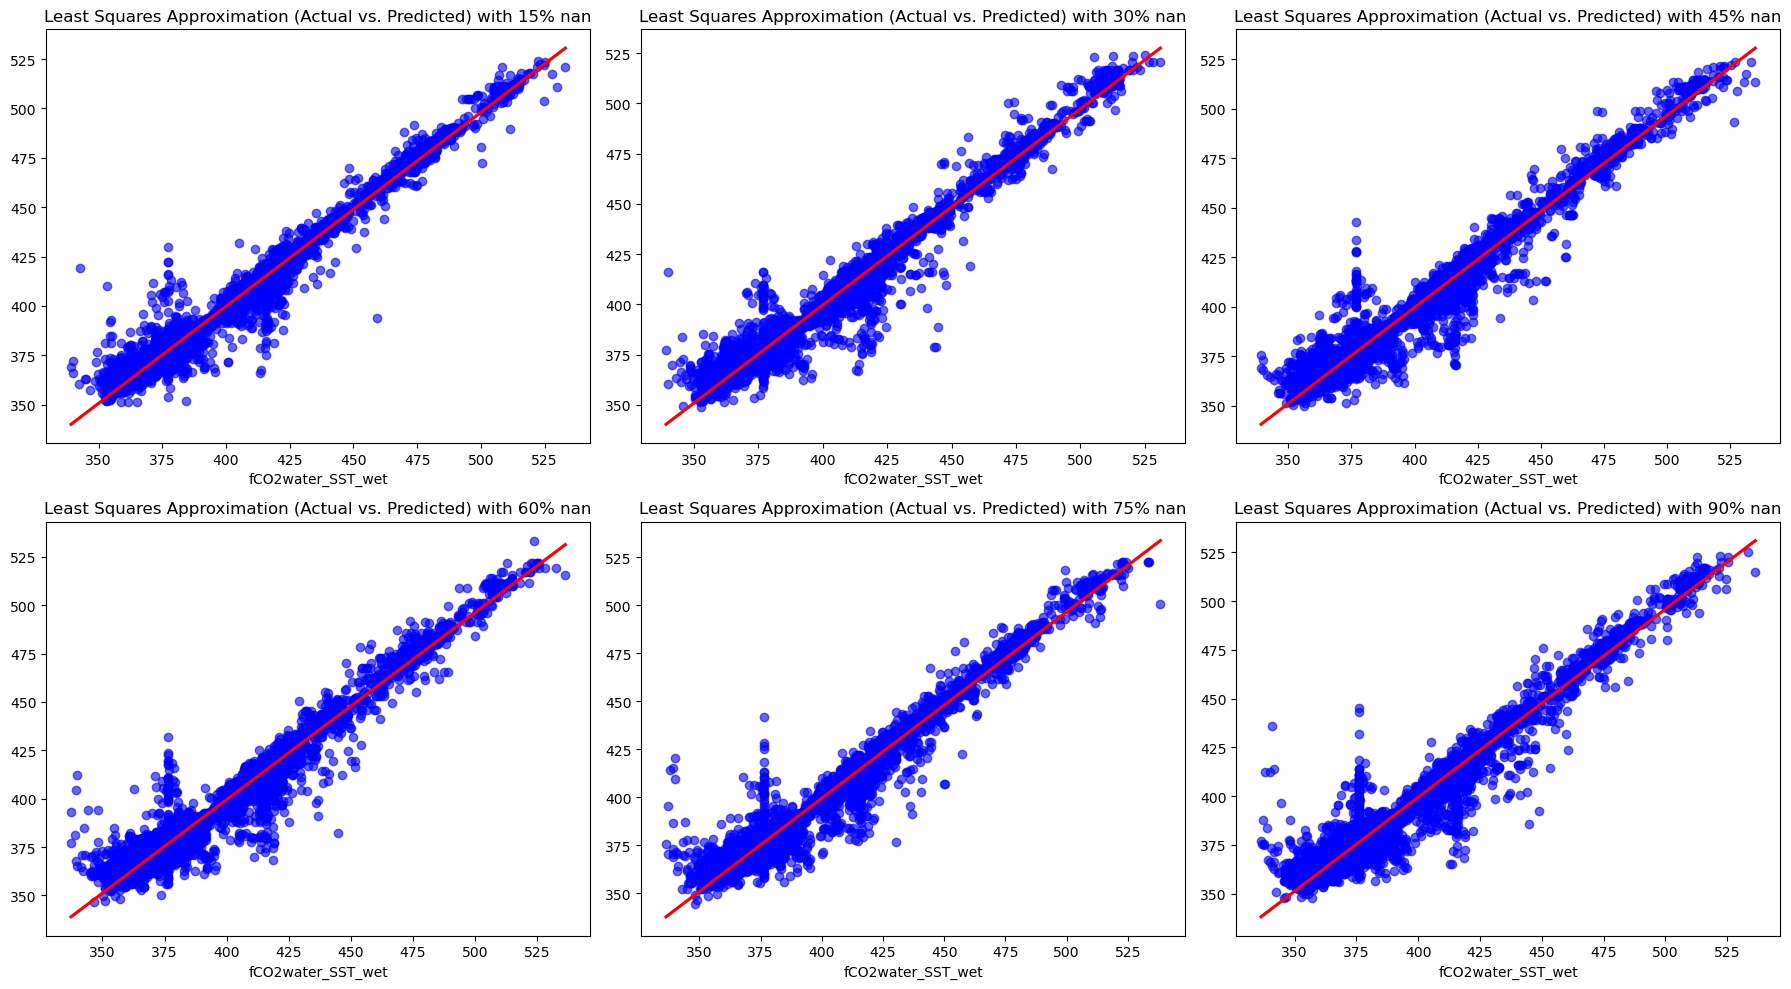

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # to fix the error AttributeError: 'numpy.ndarray' object has no attribute 'plot'

sns.regplot(x=y_test1, y=y_pred1, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"}, ax=axes[0], ci=None)
axes[0].set_title("Least Squares Approximation (Actual vs. Predicted) with 15% nan")

sns.regplot(x=y_test2, y=y_pred2, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"}, ax=axes[1], ci=None)
axes[1].set_title("Least Squares Approximation (Actual vs. Predicted) with 30% nan")

sns.regplot(x=y_test3, y=y_pred3, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"}, ax=axes[2], ci=None)
axes[2].set_title("Least Squares Approximation (Actual vs. Predicted) with 45% nan")

sns.regplot(x=y_test4, y=y_pred4, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"}, ax=axes[3], ci=None)
axes[3].set_title("Least Squares Approximation (Actual vs. Predicted) with 60% nan")

sns.regplot(x=y_test5, y=y_pred5, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"}, ax=axes[4], ci=None)
axes[4].set_title("Least Squares Approximation (Actual vs. Predicted) with 75% nan")

sns.regplot(x=y_test6, y=y_pred6, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"}, ax=axes[5], ci=None)
axes[5].set_title("Least Squares Approximation (Actual vs. Predicted) with 90% nan")

plt.tight_layout()
plt.savefig('Nan_fco2_arabian.png', dpi=1000)
plt.show()